In [ ]:
import numpy as np
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, random_rotation, random_zoom, random_shift
from IPython.display import Image
import tensorflow

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab import files

In [ ]:
# mount google drive
from google.colab import drive              
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# set up for dataset download
!rm -r sample_data

!mkdir -p ~/.kaggle
!cp "drive/My Drive/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset
!kaggle datasets download henryhaefliger/deepseawaste
!unzip -q  deepseawaste.zip
!rm -r deepseawaste.zip

100% 4.98M/4.98M [00:00<00:00, 31.8MB/s]



In [ ]:
# function for label conversions
def classes_to_vector(c):
    v = np.zeros(len(classes))

    for i in c:
        v[classes.index(i)] = 1

    return v

In [ ]:
# load the dataset

# get the paths to images and their labels
with open('dataset.csv', 'r') as f:
    data = f.read().replace(' (Several)', '').replace(' (Many)', '').split('\n')[1:]
    data = [line.split('|') for line in data]
    x, y = [line[0] for line in data], [line[1] for line in data]
    x = ['images/' + line.split('/')[-1] for line in x]
    y = [line.split(',') for line in y]

# find each unique class
classes = []
for line in y:
    for i in line:
        if not(i in classes):
            classes.append(i)

# shuffle the dataset
x = np.array(x)
y = np.array([classes_to_vector(i) for i in y]) # convert classes to 1/0 array
i = np.arange(len(x))
np.random.shuffle(i)
x, y = x[i], y[i]

In [ ]:
# data generator (to be improved with data augmentation)
class dataGen(Sequence):
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        # calculate the number of batches in an epoch
        return int(len(self.x)/self.batch_size)

    def __getitem__(self, idx):
        # get the batch
        x = self.x[idx*self.batch_size:(idx+1)*self.batch_size] 
        y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]

        # load the images
        x = np.array([img_to_array(load_img(img, target_size=(299,299))) for img in x])
        x = np.array([random_rotation(img, 180, row_axis=0, col_axis=1, channel_axis=2) for img in x])
        x = np.array([random_zoom(img, (0.2, 0.2), row_axis=0, col_axis=1, channel_axis=2) for img in x])
        x = np.array([random_shift(img, 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2) for img in x])

        return x, y

In [ ]:
# if we train our own model
model = Xception(weights='imagenet', include_top=False)
model.trainable = False

# adapting the model to our labels (keeping the same layer names as the original)
inner = GlobalAveragePooling2D(name='avg_pool')(model.output)
inner = Dense(len(classes), activation='sigmoid', name="predictions")(inner)
model = Model(inputs=model.input, outputs=inner)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
%load_ext tensorboard

In [ ]:
# fit the model
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='tb')

train = dataGen(x, y, 8)
model.fit(train, steps_per_epoch=len(train), epochs=5, workers=4, max_queue_size=10, callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir tb

In [ ]:
model.save('detection2.h5')

In [ ]:
# if we use the pretrained model
model = Xception(weights='imagenet', include_top=True)

In [ ]:
model = load_model('detection2.h5')

In [ ]:
# function for creating heatmap (CAM method)
def make_gradcam_heatmap(img_array, model):
    # model without labelling layers
    last_conv_layer = model.get_layer("block14_sepconv2_act")
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # only the labelling layers
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = model.get_layer("avg_pool")(classifier_input)
    x = model.get_layer("predictions")(x)
    classifier_model = Model(classifier_input, x)

    # we calculate the gradient for the highest probability class with respect to the last conv layer
    with tf.GradientTape() as tape: # automatic differentiation
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output) # compute gradient

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # the mean intensity of the gradient over a feature ("how important each channel is")

    # we multiply each channel by it's importance
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # create heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap)) # heatmap is normalized between 0 and 1
    return heatmap

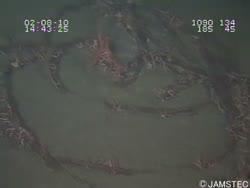

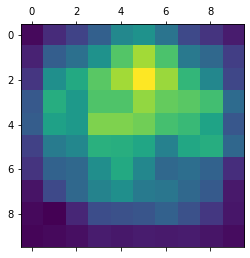

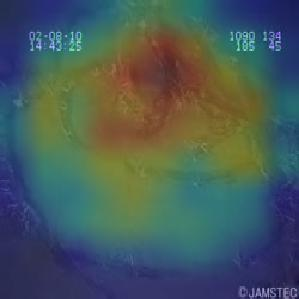

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

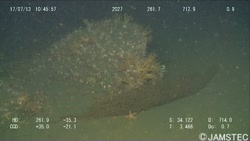

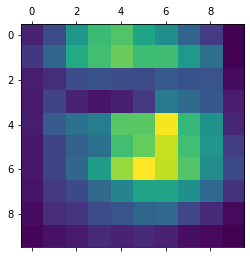

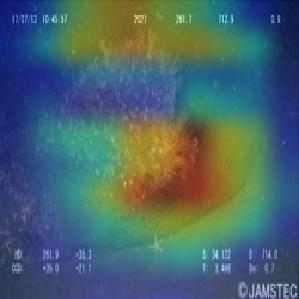

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

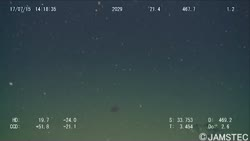

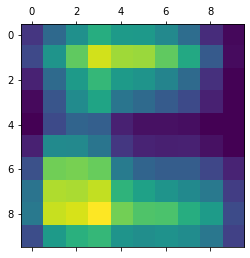

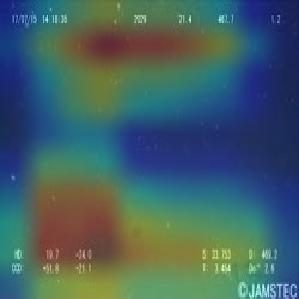

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

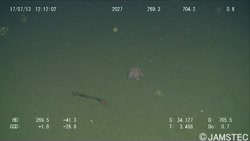

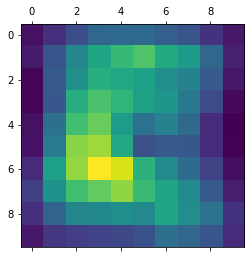

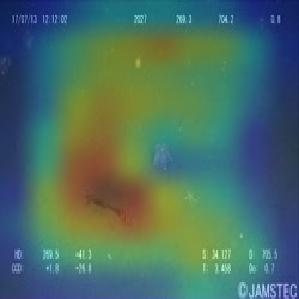

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

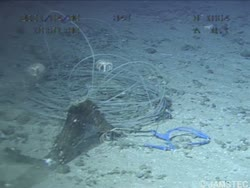

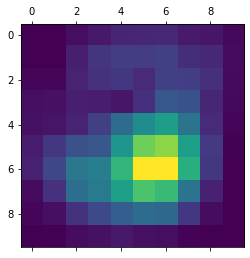

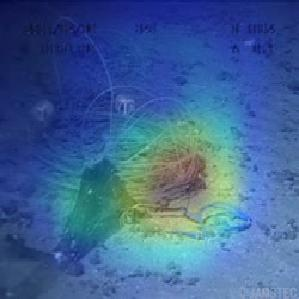

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

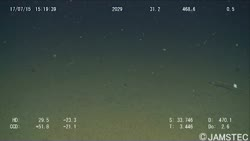

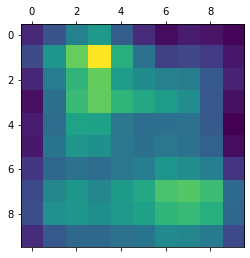

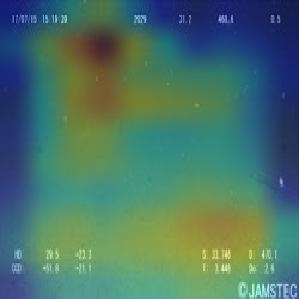

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

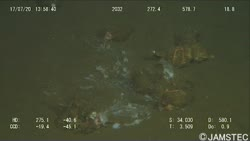

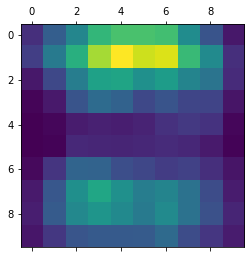

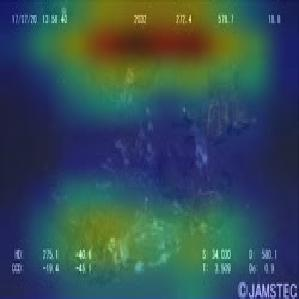

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

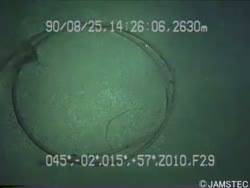

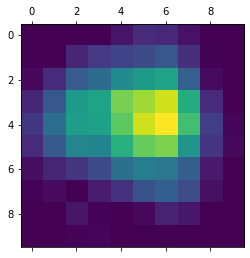

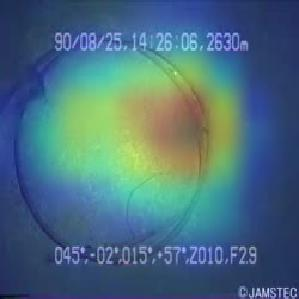

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

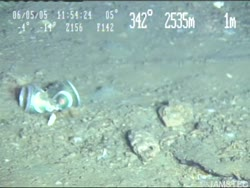

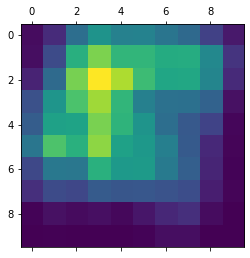

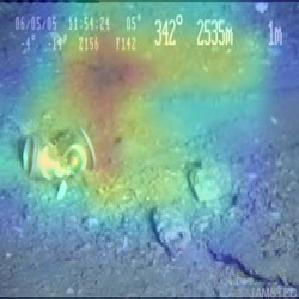

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

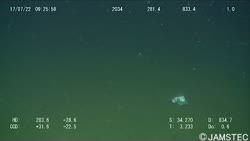

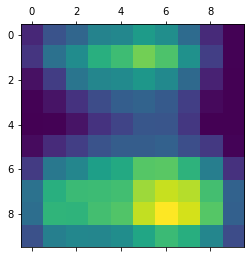

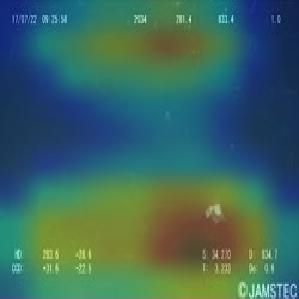

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

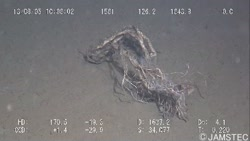

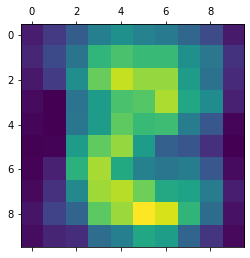

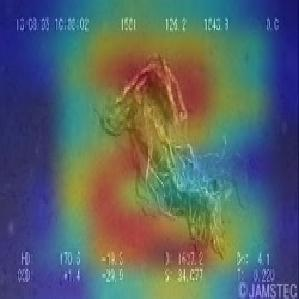

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

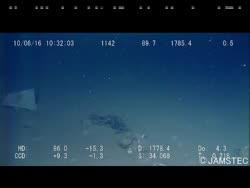

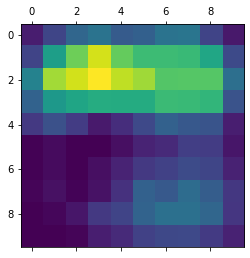

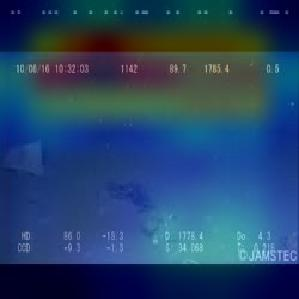

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

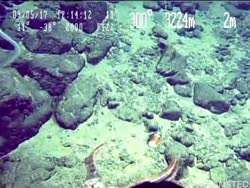

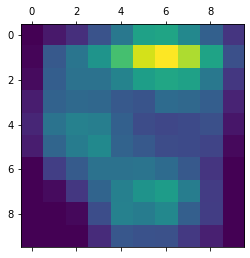

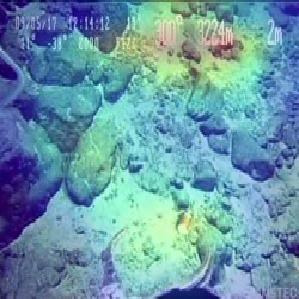

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

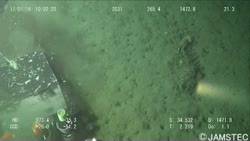

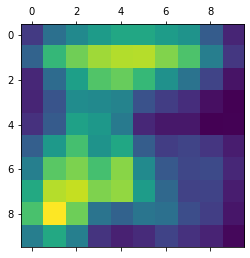

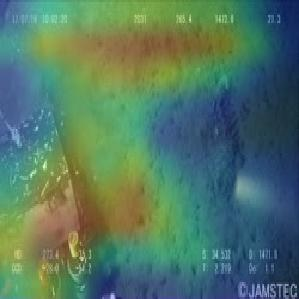

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

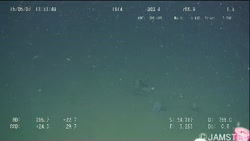

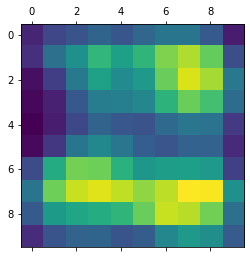

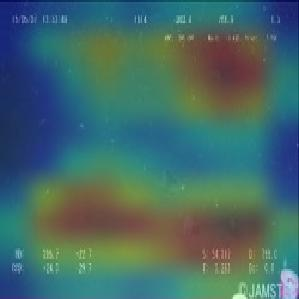

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

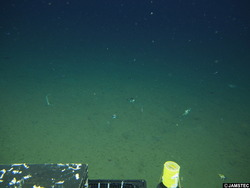

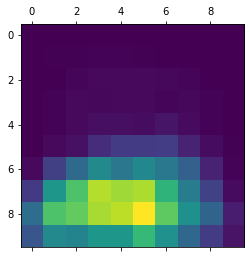

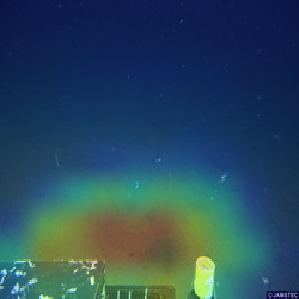

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

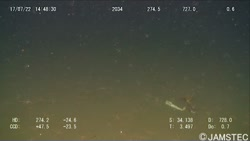

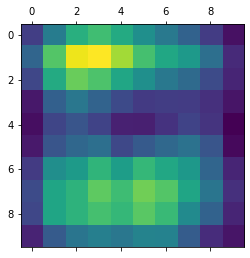

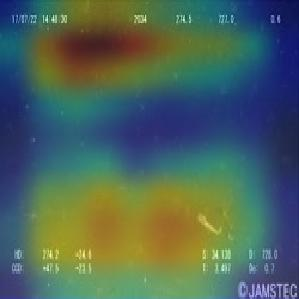

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

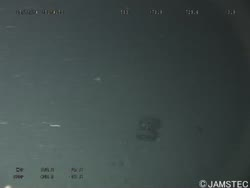

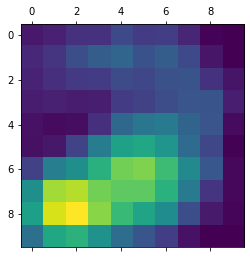

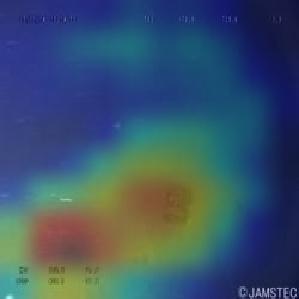

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

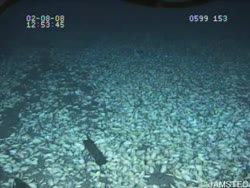

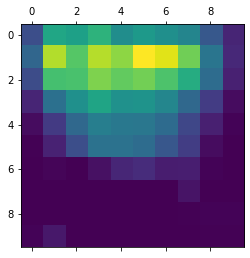

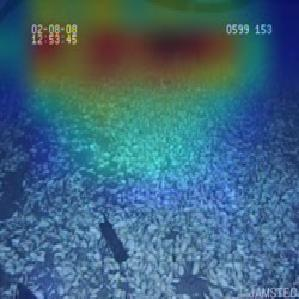

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

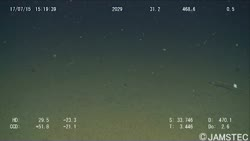

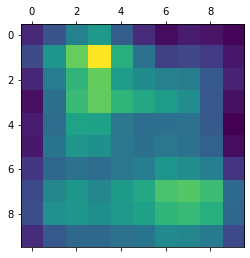

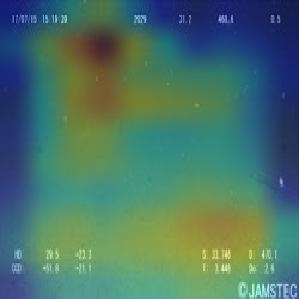

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

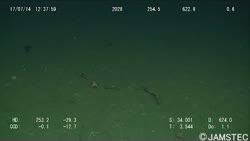

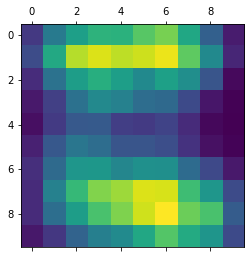

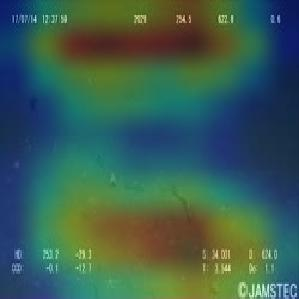

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

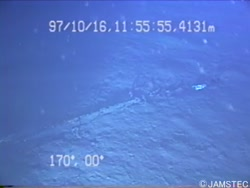

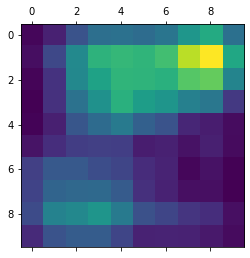

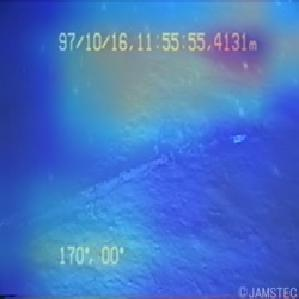

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

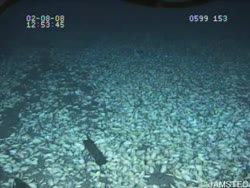

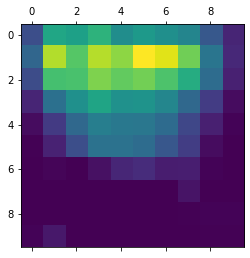

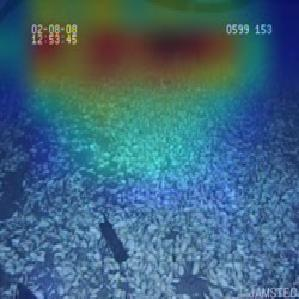

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

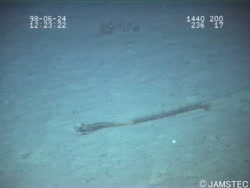

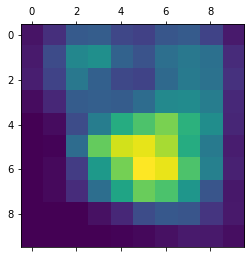

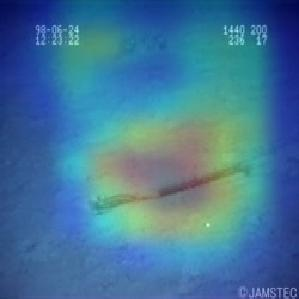

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

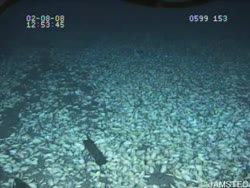

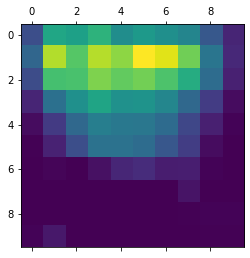

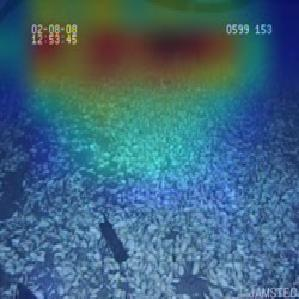

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

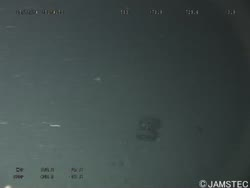

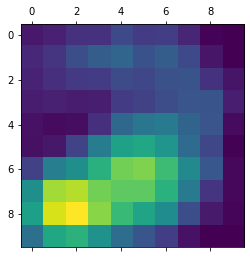

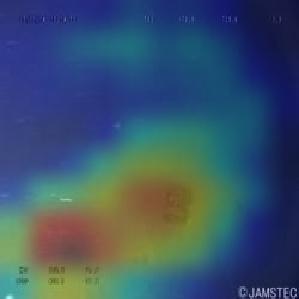

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

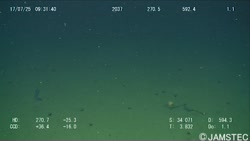

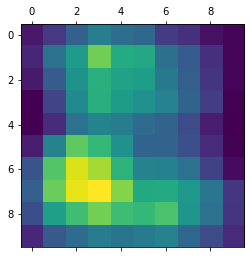

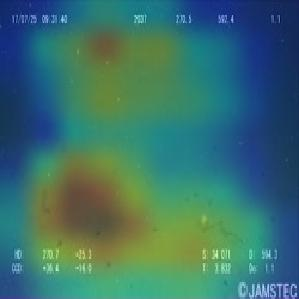

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

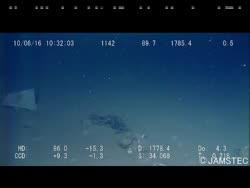

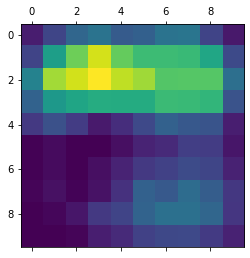

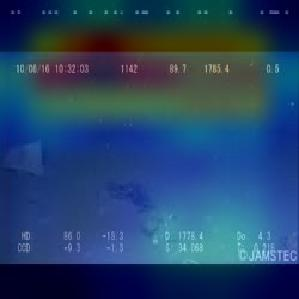

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

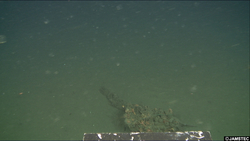

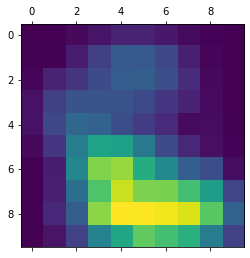

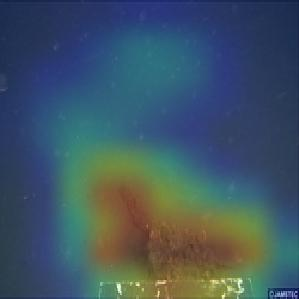

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

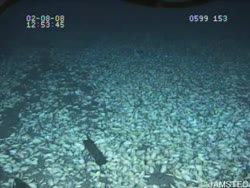

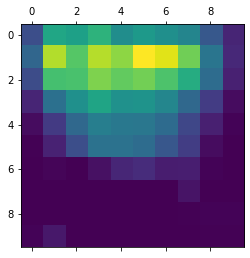

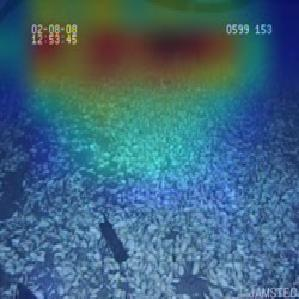

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

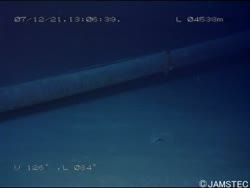

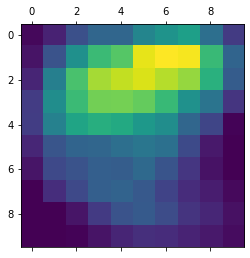

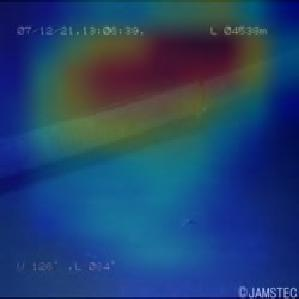

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

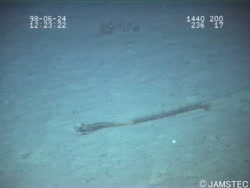

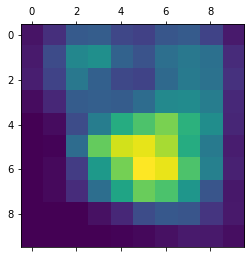

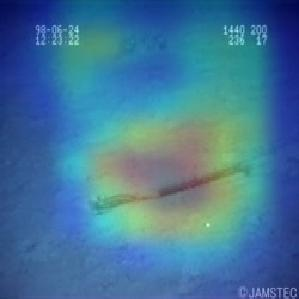

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

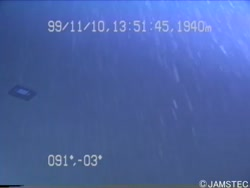

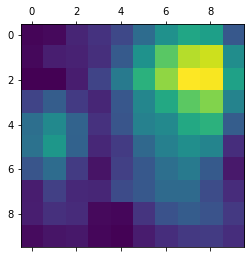

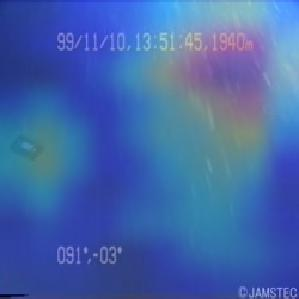

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

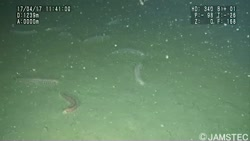

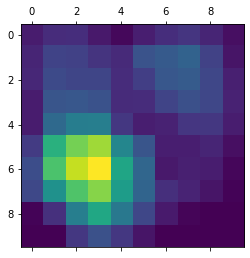

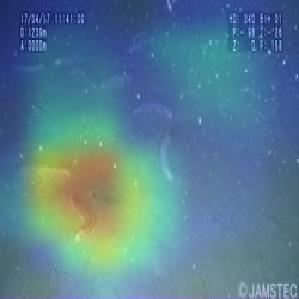

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

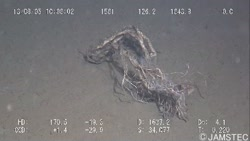

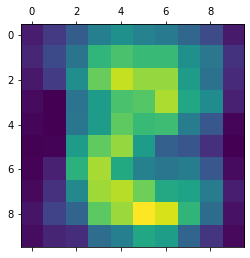

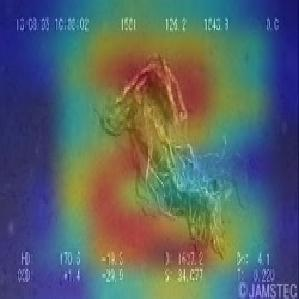

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

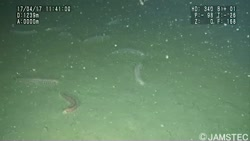

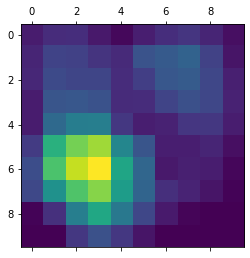

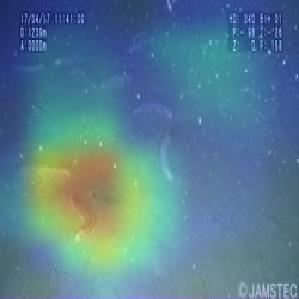

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

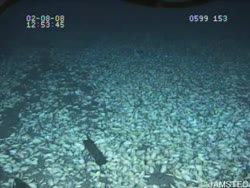

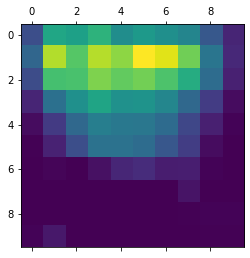

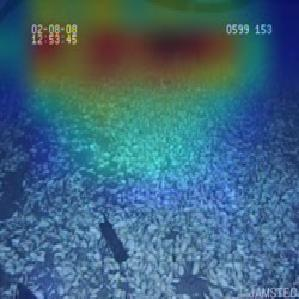

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

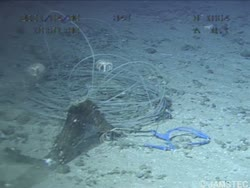

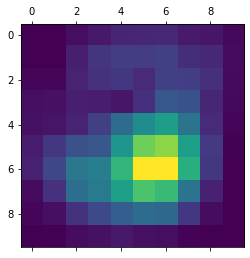

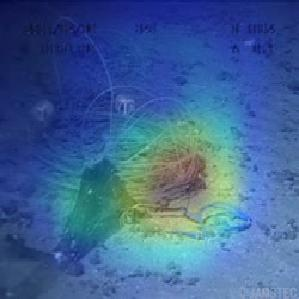

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

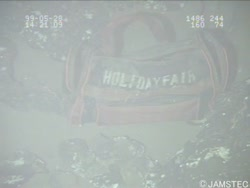

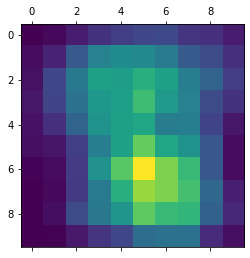

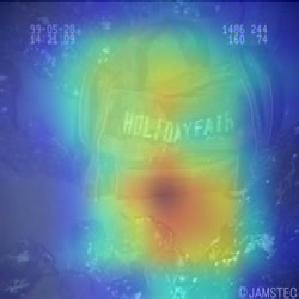

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

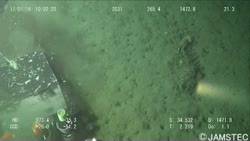

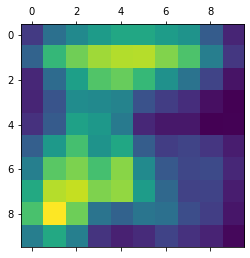

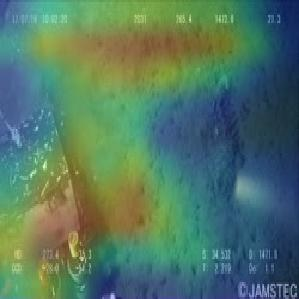

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

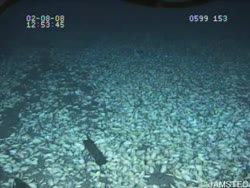

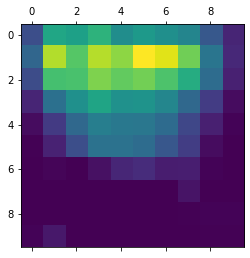

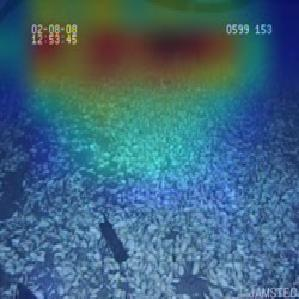

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

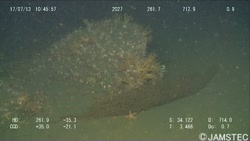

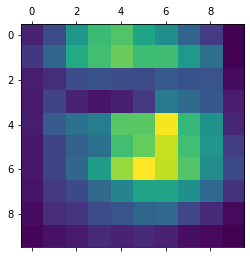

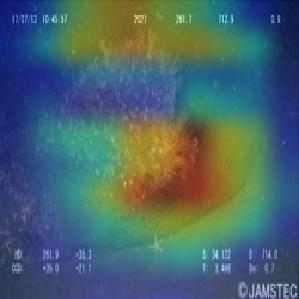

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

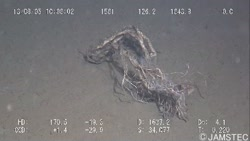

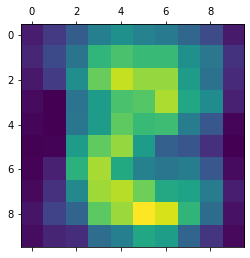

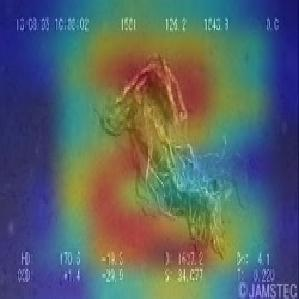

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

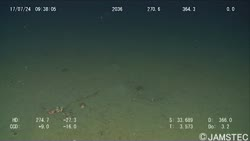

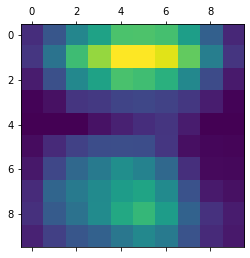

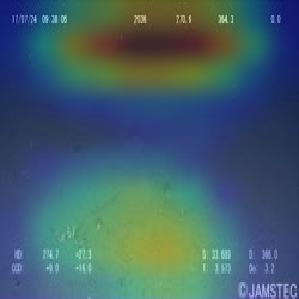

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

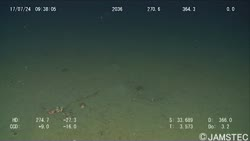

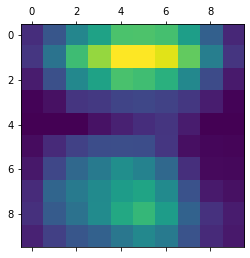

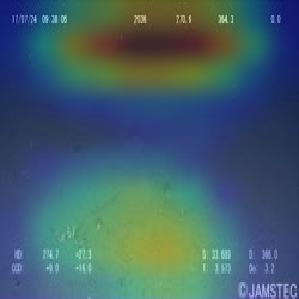

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

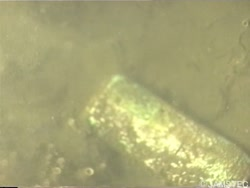

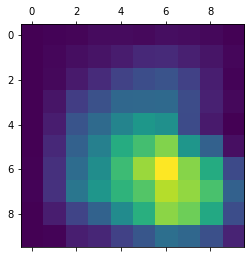

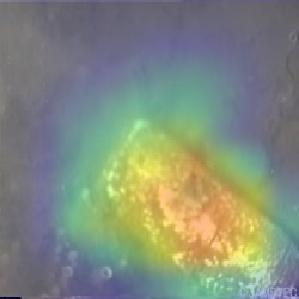

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

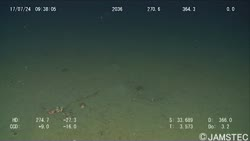

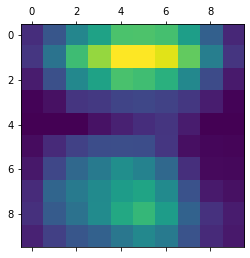

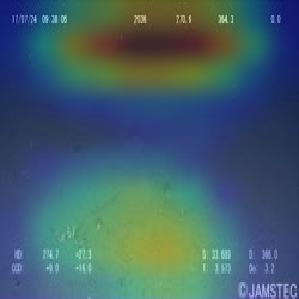

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

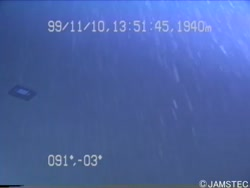

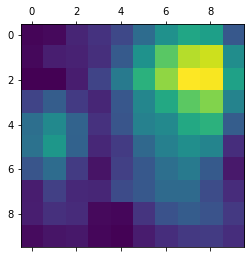

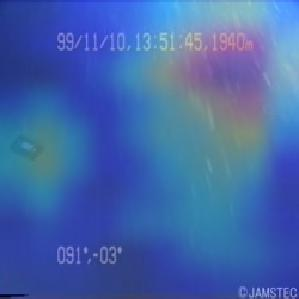

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

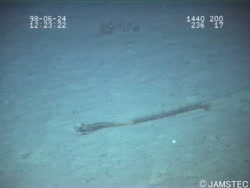

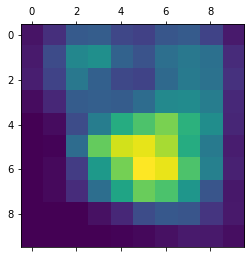

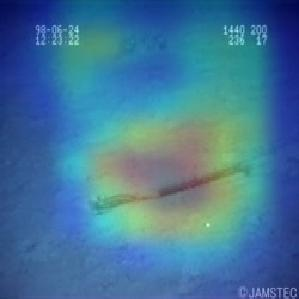

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

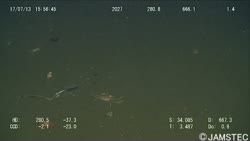

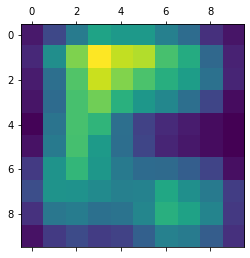

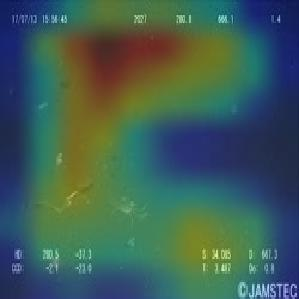

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(50):
    # choose a demo image from the dataset
    img_path = x[i]

    # show the original image
    display(Image(img_path))

    # load image
    img = img_to_array(load_img(img_path, target_size=(299,299)))
    img_array = preprocess_input(np.expand_dims(img, axis=0))

    # create heatmap from image and model
    heatmap = make_gradcam_heatmap(img_array, model)

    # show the raw heatmap
    plt.matshow(heatmap)
    plt.show()

    # overlay the heatmap and image
    heatmap = np.uint8(255 * heatmap) # heatmap to rgb (0-255)

    # we create an image from the heatmap
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((299, 299)) # matching original image size
    jet_heatmap = img_to_array(jet_heatmap)

    # we overlay the two images
    superimposed_img = jet_heatmap * 0.003 + img # the heatmap is weighted so that we can see the image through it
    superimposed_img = array_to_img(superimposed_img) # create new image

    array_to_img(img).save('original_' + img_path.split('/')[1])
    superimposed_img.save('heatmap_' + img_path.split('/')[1]) # save the image for download

    display(Image('heatmap_' + img_path.split('/')[1])) # preview the image

    files.download('original_' + img_path.split('/')[1])
    files.download('heatmap_' + img_path.split('/')[1])